In [1]:
import os
import sys
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings


In [2]:
warnings.filterwarnings('ignore')
path = os.getenv("ROOT_PATH")
sys.path.append(path)
print(path)


/Users/monic/Desktop/Master_Thesis/empirical


The list of **all the current components** of the OMX Stockholm PI index can be found [here](https://indexes.nasdaqomx.com/Index/Weighting/OMXSPI) by the end of the day of 16th February 2024.

The list of **large-caps** of the OMX Stockholm PI index can be found [here](https://indexes.nasdaqomx.com/Index/Weighting/OMXSLCPI) by the end of the day of 16th February 2024.

The list of **mid-caps** of the OMX Stockholm PI index can be found [here](https://indexes.nasdaqomx.com/Index/Weighting/OMXSMCPI) by the end of the day of 16th February 2024.

The list of **small-caps** of the OMS Stockholm PI index can be found [here](https://indexes.nasdaqomx.com/Index/Weighting/OMXSSCPI) by the end of the day of 16th February 2024.


In the following steps we're charging the name of all the components and turn them into a list.

The latter will be used to fetch the data - adjusted closed price and volume - from Yahoo Finance. And save accordingly in a file called `raw_data.csv`

In [ ]:
tickers= pd.read_excel(f"{path}/raw_data/main/Weightings_20240216_OMXSPI.xlsx",header=0)
# If error shows up run: !pip3 install xlrd


In [ ]:
tickers.head()


,Company Name,Security-Symbol
0,TRATON SE,8TRA.ST
1,AAK AB,AAK.ST
2,ABB Ltd,ABB.ST
3,Abliva AB,ABLI.ST
4,AcadeMedia AB,ACAD.ST


In [ ]:
tickers_list=tickers['Security-Symbol'].to_list()


In [ ]:
data = yf.download(tickers_list, start="2014-03-06")


[*********************100%%**********************]  393 of 393 completed


In [ ]:
data.head()


In [ ]:
data.to_csv(f"{path}/raw_data/raw_data.csv")


During the following cells we are going to create different lists with the names of the companies considered large-caps, mid-caps, and small caps.

In [5]:
l_caps=pd.read_excel(f"{path}/raw_data/main/large_caps.xlsx")
l_caps_list=l_caps['Security-Symbol'].to_list()


In [6]:
m_caps=pd.read_excel(f"{path}/raw_data/main/mid_caps.xlsx")
m_caps_list=m_caps['Security-Symbol'].to_list()


In [7]:
s_caps=pd.read_excel(f"{path}/raw_data/main/small_caps.xlsx")
s_caps_list=s_caps['Security-Symbol'].to_list()


In [1]:
len(tickers_list)


NameError: name 'df_price' is not defined

There is one company that we cannot classify as large, mid or small-cap. 

It'll be pointed out in the following steps.

## Cleaning data

After downloading the data in the file `raw_data.csv` you must open it in Microsoft Excel.
In the **first row** we can find the number of the metric fetched.
In the **second row** we can find the names of the different companies.
In the **first column** we can find the dates we have exported.

To clean up the dataset, delete those columns where the first row differs from `adjClose` and `volume`.
As soon as this is done, cut those columns where the first row is `volume` and paste them in a new spreadsheet (not tab). 
Remove the first row as it doesn't add useful information at the moment. Call `volumes` to this new spreadsheet and save it as a .csv file.

Come back to the initial spreadsheet called `raw_data.csv`. 
Since we only have `adjClose` prices, remove the first row.
Rename the spreadsheet as `price` and save it as a .csv file



In [3]:
df_price = pd.read_excel(f'{path}/raw_data/main/price.xlsx')


In [4]:
print(f"Number of companies in the sample: {df_price.shape[1]-2}") # Excluding the 'Date' and '^OMXSPI' columns.


Number of companies in the sample: 393


In [9]:
null_percentage_dict={'Company':[],'Null_percentage':[],'Type':[]}

for column in df_price.columns[1:-1]:
    company_name=column
    null_percentage = df_price[company_name].isnull().mean()*100
    null_percentage_dict['Company'].append(company_name)
    null_percentage_dict['Null_percentage'].append(null_percentage)
    if company_name in l_caps_list:
        null_percentage_dict['Type'].append("l-cap")
    elif company_name in m_caps_list:
        null_percentage_dict['Type'].append("m-cap")
    elif company_name in s_caps_list:
        null_percentage_dict['Type'].append("s-cap")
    else: null_percentage_dict['Type'].append("non-registered")

df_null_percentage=pd.DataFrame.from_dict(null_percentage_dict)


In [10]:
df_null_percentage[df_null_percentage['Type']=="non-registered"]


,Company,Null_percentage,Type
249,NOKIA-SEK.ST,0.0,non-registered


In [11]:
df_null_percentage=df_null_percentage.sort_values(by="Null_percentage",ascending=False)

df_null_percentage.head()


,Company,Null_percentage,Type
152,HAKI-B.ST,98.282748,s-cap
294,RUSTA.ST,96.725240,m-cap
301,SAMPO-SDB.ST,87.500000,l-cap
15,ALLEI.ST,85.143770,l-cap
252,NORION.ST,84.664537,m-cap


In [12]:
df_null_percentage.to_excel(f'{path}/raw_data/main/null_percentage.xlsx')


In [14]:
fig = px.bar(df_null_percentage, x='Company', y='Null_percentage', color='Type',
             labels={'Null_percentage': 'Null_percentage'},
             title='Null Percentage of Companies by Cap Classification',
             hover_data=['Company', 'Null_percentage', 'Type'])
fig.update_layout(barmode='group', xaxis_title='Company', yaxis_title='Null_percentage')
fig.show()


Components over time of the OMXSPI [here](https://indexes.nasdaqomx.com/Index/Weighting/OMXSPI)

Methodology of the index [here](https://indexes.nasdaqomx.com/docs/Methodology_Nordic_AllShare.pdf)

## Proxy A:

Daily raw stock returns with absolute values exceeding 8% and 10%

In [15]:
threshold_8_percent = 0.08
threshold_10_percent = 0.10

proxy_a_df = pd.DataFrame(df_price['Date'].copy())


In [16]:
for column in df_price.columns[1:-1]:  # Excluding the 'Date' and '^OMXSPI' columns.

    stock_returns = df_price[column].pct_change()

    # Create proxy columns based on the defined thresholds
    proxy_a_df[f'{column}_Proxy_A_8%'] = (abs(stock_returns) > threshold_8_percent).astype(int)
    proxy_a_df[f'{column}_Proxy_A_10%'] = (abs(stock_returns) > threshold_10_percent).astype(int)

index_returns = df_price['^OMXSPI'].pct_change()
proxy_a_df['OMXSPI_Return_Direction'] = (index_returns > 0).astype(int)


proxy_a_df.to_excel(f'{path}/raw_data/main/proxy_a.xlsx')


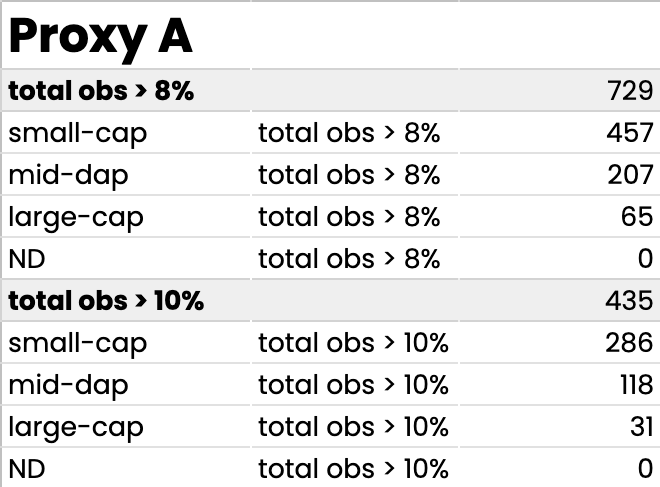

## Proxy B:

Daily raw stock returns with absolute values exceeding 3 and 4 standard deviations.

In [ ]:
price_2013 = yf.download(tickers_list, start="2013-03-06")


In [17]:
threshold_3_std = 3
threshold_4_std = 4
window_size = 250 # Number of trading days for calculating the rolling standard deviation
df_price_2013 = pd.read_excel(f"{path}/raw_data/main/price_2013.xlsx")

proxy_b_df = pd.DataFrame(df_price['Date'].copy())


Index(['Date'], dtype='object')

In [18]:
for column in df_price_2013.columns[1:-1]:  # Exclude the 'Date' and '^OMXSPI' columns
    stock_returns = df_price_2013[column].pct_change()
    rolling_std = stock_returns.rolling(window=window_size).std()
    result_df = pd.DataFrame({
    'Date': df_price_2013['Date'],
    'Stock_Returns': stock_returns,
    'Rolling_Std': rolling_std
})

    result_df[f'{column}_Proxy_B_3std'] = (abs(stock_returns) > threshold_3_std * rolling_std).astype(int)
    result_df[f'{column}_Proxy_B_4std'] = (abs(stock_returns) > threshold_4_std * rolling_std).astype(int)

    result_df = result_df[result_df['Date']>='2014-03-06']
    result_df.drop(columns=['Stock_Returns','Rolling_Std'],inplace=True)
    proxy_b_df=pd.merge(proxy_b_df,result_df,left_on='Date', right_on='Date', how='left')
proxy_b_df.head()

index_returns = df_price['^OMXSPI'].pct_change()

proxy_b_df['OMXSPI_Return_Direction'] = (index_returns > 0).astype(int)

proxy_b_df.to_excel(f'{path}/raw_data/main/proxy_b.xlsx')


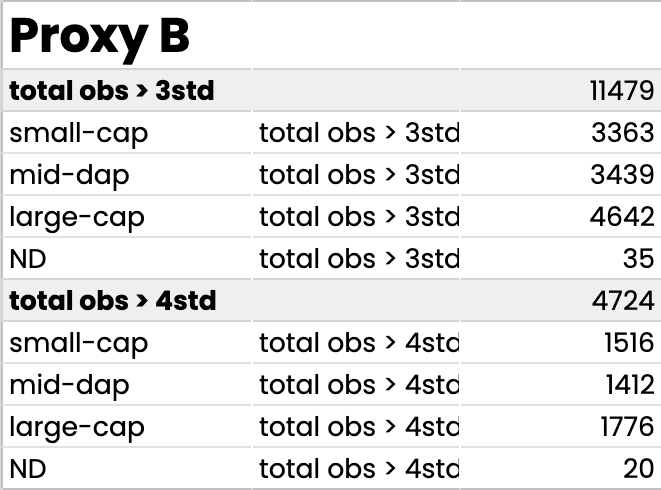

In [19]:
proxy_b_df.head()


,Date,8TRA.ST_Proxy_B_3std,8TRA.ST_Proxy_B_4std,AAK.ST_Proxy_B_3std,AAK.ST_Proxy_B_4std,ABB.ST_Proxy_B_3std,ABB.ST_Proxy_B_4std,ABLI.ST_Proxy_B_3std,ABLI.ST_Proxy_B_4std,ACAD.ST_Proxy_B_3std,...,WTW-A.ST_Proxy_B_4std,XANO-B.ST_Proxy_B_3std,XANO-B.ST_Proxy_B_4std,XBRANE.ST_Proxy_B_3std,XBRANE.ST_Proxy_B_4std,XSPRAY.ST_Proxy_B_3std,XSPRAY.ST_Proxy_B_4std,XVIVO.ST_Proxy_B_3std,XVIVO.ST_Proxy_B_4std,OMXSPI_Return_Direction
0,2014-03-06,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-03-07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-03-10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2014-03-11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-03-12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Proxy C

Daily abnormal stock returns with absolute values exceeding 8% and 10% using Market Model Adjusted Returns

In [23]:
threshold_8_percent = 0.08
threshold_10_percent = 0.10
window_size = 250  # Number of trading days for estimating beta

risk_free_rate_df= pd.read_excel(f"{path}/raw_data/main/risk_free.xlsx")

proxy_c_df = pd.DataFrame(df_price['Date'].copy())


for column in df_price_2013.columns[1:-1]:  # Exclude the 'Date' and '^OMXSPI' column

    stock_returns = df_price_2013[column].pct_change()

    # Market returns (e.g., using OMXSPI as a proxy for the market)
    market_returns = df_price_2013['^OMXSPI'].pct_change()

    # beta over the preceding 250 trading days


    result_df = pd.DataFrame({
    'Date': df_price_2013['Date'],
    'Stock_Returns': stock_returns,
    'Market_Returns': market_returns
})
    result_df['beta'] = result_df['Stock_Returns'].rolling(window=window_size).cov(result_df['Market_Returns']).div(result_df['Market_Returns'].rolling(window=window_size).var())
    result_df = pd.merge(result_df,risk_free_rate_df, left_on='Date', right_on='Date', how='left')
    result_df['Swedish Treasury Bills (SE TB 1 Month)'].fillna(method='ffill', inplace=True)

    result_df['MMAR'] = result_df['Stock_Returns'] - (result_df['Market_Returns']+ result_df['beta'] * (result_df['Market_Returns'] - result_df['Swedish Treasury Bills (SE TB 1 Month)']))

    result_df[f'{column}_ARs'] = result_df['Stock_Returns'] - result_df['MMAR']

    result_df.drop(columns=['Stock_Returns','Market_Returns','beta','Swedish Treasury Bills (SE TB 1 Month)','MMAR'],inplace=True)

    proxy_c_df = pd.merge(proxy_c_df,result_df, left_on='Date',right_on='Date',how='left')

    proxy_c_df[f'{column}_Proxy_C_8%'] = (abs(proxy_c_df[f'{column}_ARs']) > threshold_8_percent).astype(int)
    proxy_c_df[f'{column}_Proxy_C_10%'] = (abs(proxy_c_df[f'{column}_ARs']) > threshold_10_percent).astype(int)
    proxy_c_df.drop(columns=[f'{column}_ARs'],inplace=True)

proxy_c_df.to_excel(f"{path}/raw_data/main/proxy_c.xlsx")


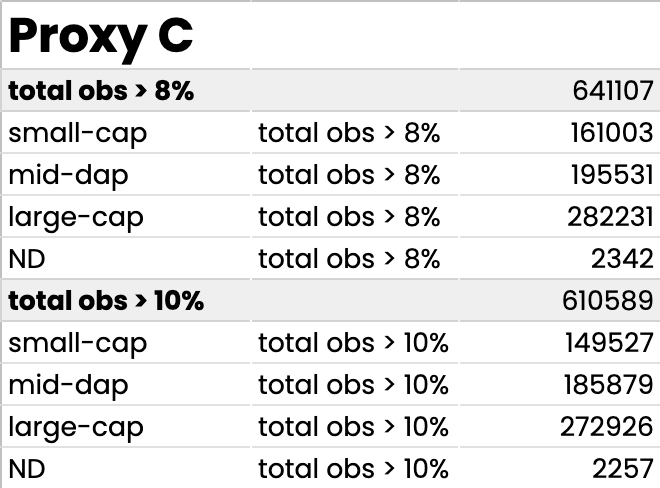